In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.models import Word2Vec
from joblib import load, dump

In [2]:
path_sentiment_data    = "../Data/PREP/sentiment_full.parquet"

path_modelo_w2v        = '../Data/MODELS/modelo_word2vec_100.model'
path_modelo_clustering = '../Data/MODELS/clustering_pipeline.joblib'

In [3]:
data = pd.read_parquet(path_sentiment_data)

In [28]:
def refactor_data(data):
    return (data
            .reset_index()
            .rename(columns={'sentences':'phrase', 'page':'n_page', 'sentence':'n_phrase'},)
            .set_index(['bank','year', 'n_page', 'n_phrase']))

def palabra_en_modelo(palabra,w2v):
    try:
        w2v.wv.get_vector(palabra)
        return True
    except:
        return False

def vectorize_text(texto_vector, w2v, SIZE_VECTORS=100):
    # Complete here the code
    vectors = [w2v.wv.get_vector(i) for i in texto_vector if palabra_en_modelo(i,w2v)]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(SIZE_VECTORS)

def apply_phrase_clustering(data, path_word2vec, path_clustering, SIZE_VECTORS=100):
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
    data = refactor_data(data)
    
    word2vec = Word2Vec.load(path_modelo_w2v)
    print('Tokenizing...')
    data['texto_vector'] = data.phrase.progress_apply(lambda x: [w.lower() for w in x.split(' ') if w])
    print('Aplicando Word2Vec...')
    vectors = data.texto_vector.progress_apply(lambda x: vectorize_text(x, word2vec, SIZE_VECTORS)).to_numpy()
    
    dfVectors = pd.DataFrame(np.concatenate(vectors).reshape(vectors.shape[0],SIZE_VECTORS,), index=data.index, 
                         columns=[f'WV{i}' for i in range(SIZE_VECTORS)])
    print('Aplicando Clustering...')
    clustering = load(path_modelo_clustering)
    clusters = clustering.predict(dfVectors)
    data['cluster'] = clusters
    data = data.dropna()
    
    return data

def plotWordCloud(arrayWords, colormap='inferno'):
    # Plot word cloud with higher frequency hashtags appearing larger
    from wordcloud import WordCloud
    from PIL import Image
    import matplotlib.pyplot as plt
    wordcloud = WordCloud(
        #font_size=15,
        #font_family='Arial',
        scale=3,
        colormap=colormap,
        background_color='white',
        min_word_length=3,
        #max_words=200,
        #margin=10,
        mask = np.array(Image.open('images/bank-mask.png'))
    )
    wordcloud.generate("+".join(arrayWords))
    fig, ax = plt.subplots(figsize=(20,10), dpi=300)
    ax.imshow(wordcloud)
    ax.axis("off")
    plt.show()

In [21]:
from wordcloud import WordCloud

In [7]:
cluster_df = apply_phrase_clustering(data,
                                     path_modelo_w2v,       
                                     path_modelo_clustering
                                    )

Tokenizing...


100%|██████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [00:08<00:00, 144192.98it/s]


Aplicando Word2Vec...


100%|███████████████████████████████████████████████████████████████████████████████████████| 1202495/1202495 [01:02<00:00, 19170.53it/s]


Aplicando Clustering...


In [8]:
cluster_df

phrase  \
bank           year n_page n_phrase                                                      
ABBEY_NATIONAL 2003 1      1         Full Year Financial Results FebruaryFebruaryFe...   
                    2      28        Full Year Financial Results February February ...   
                           20         Summarised consolidated profit and loss account    
                           14         Personal Financial Services trading profit be...   
                           15         Portfolio Business Unit profit loss before ta...   
...                                                                                ...   
UNICREDIT      2021 840    14         VaR Value at Risk A measure of the risk of po...   
                           18        assets for a certain period of time until it r...   
                    843    1           Annual Report and Accounts Contacts UniCredit S   
                           2          Head Office in Milan P iazza Gae Aulenti Towe...   
                           3            Media Relations E mail mediarelationsunicredit   

                                     length  negative   neutral  positive  \
bank           year n_page n_phrase                                         
ABBEY_NATIONAL 2003 1      1             18  0.000068  0.999884  0.000049   
                    2      28            53  0.000074  0.999874  0.000052   
                           20             6  0.000116  0.999831  0.000053   
                           14             9  0.000086  0.999869  0.000045   
                           15             9  0.997227  0.002284  0.000489   
...                                     ...       ...       ...       ...   
UNICREDIT      2021 840    14            31  0.102616  0.896958  0.000427   
                           18            20  0.000078  0.999863  0.000058   
                    843    1              7  0.000072  0.999887  0.000041   
                           2             11  0.000070  0.999874  0.000056   
                           3              5  0.000070  0.999884  0.000046   

                                                                          texto_vector  \
bank           year n_page n_phrase                                                      
ABBEY_NATIONAL 2003 1      1         [full, year, financial, results, februaryfebru...   
                    2      28        [full, year, financial, results, february, feb...   
                           20        [summarised, consolidated, profit, and, loss, ...   
                           14        [personal, financial, services, trading, profi...   
                           15        [portfolio, business, unit, profit, loss, befo...   
...                                                                                ...   
UNICREDIT      2021 840    14        [var, value, at, risk, a, measure, of, the, ri...   
                           18        [assets, for, a, certain, period, of, time, un...   
                    843    1         [annual, report, and, accounts, contacts, unic...   
                           2         [head, office, in, milan, p, iazza, gae, aulen...   
                           3         [media, relations, e, mail, mediarelationsunic...   

                                     cluster  
bank           year n_page n_phrase           
ABBEY_NATIONAL 2003 1      1               1  
                    2      28              2  
                           20              1  
                           14              1  
                           15              1  
...                                      ...  
UNICREDIT      2021 840    14              3  
                           18              3  
                    843    1               2  
                           2               0  
                           3               0  

[1202495 rows x 7 columns]

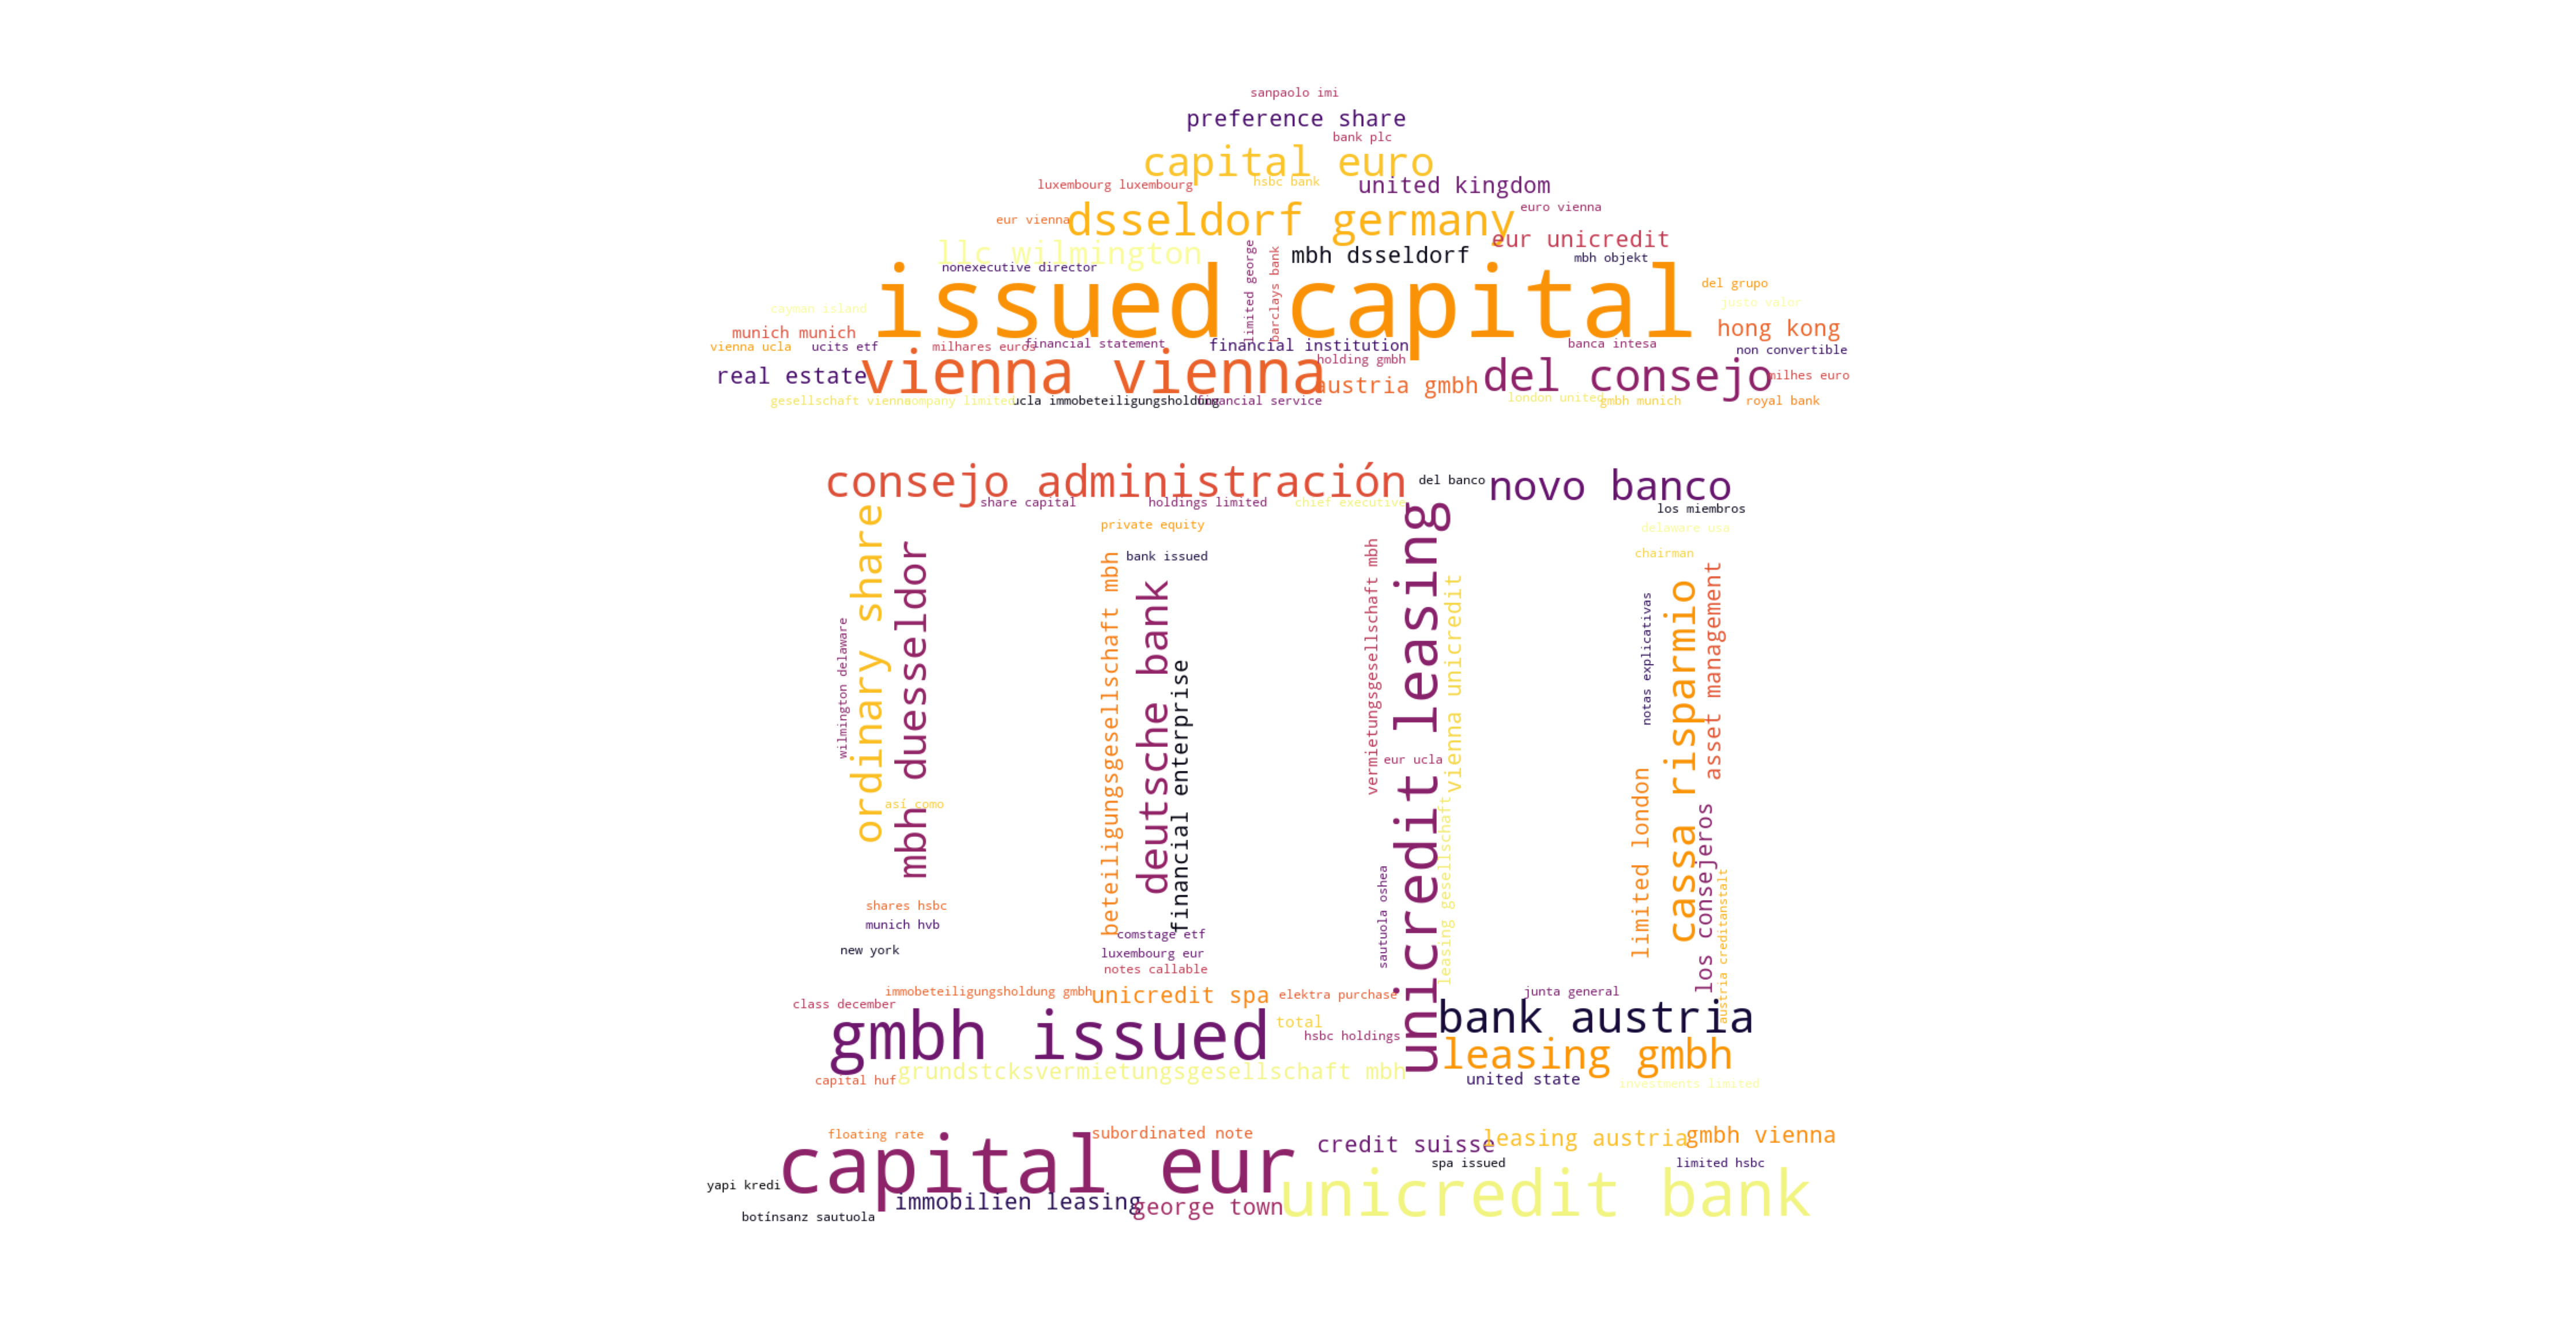

In [29]:
words_in_cluster = []

for frase in cluster_df[cluster_df.cluster == 0]['texto_vector'].to_numpy():
    words_in_cluster.extend(frase)
    
plotWordCloud(words_in_cluster)

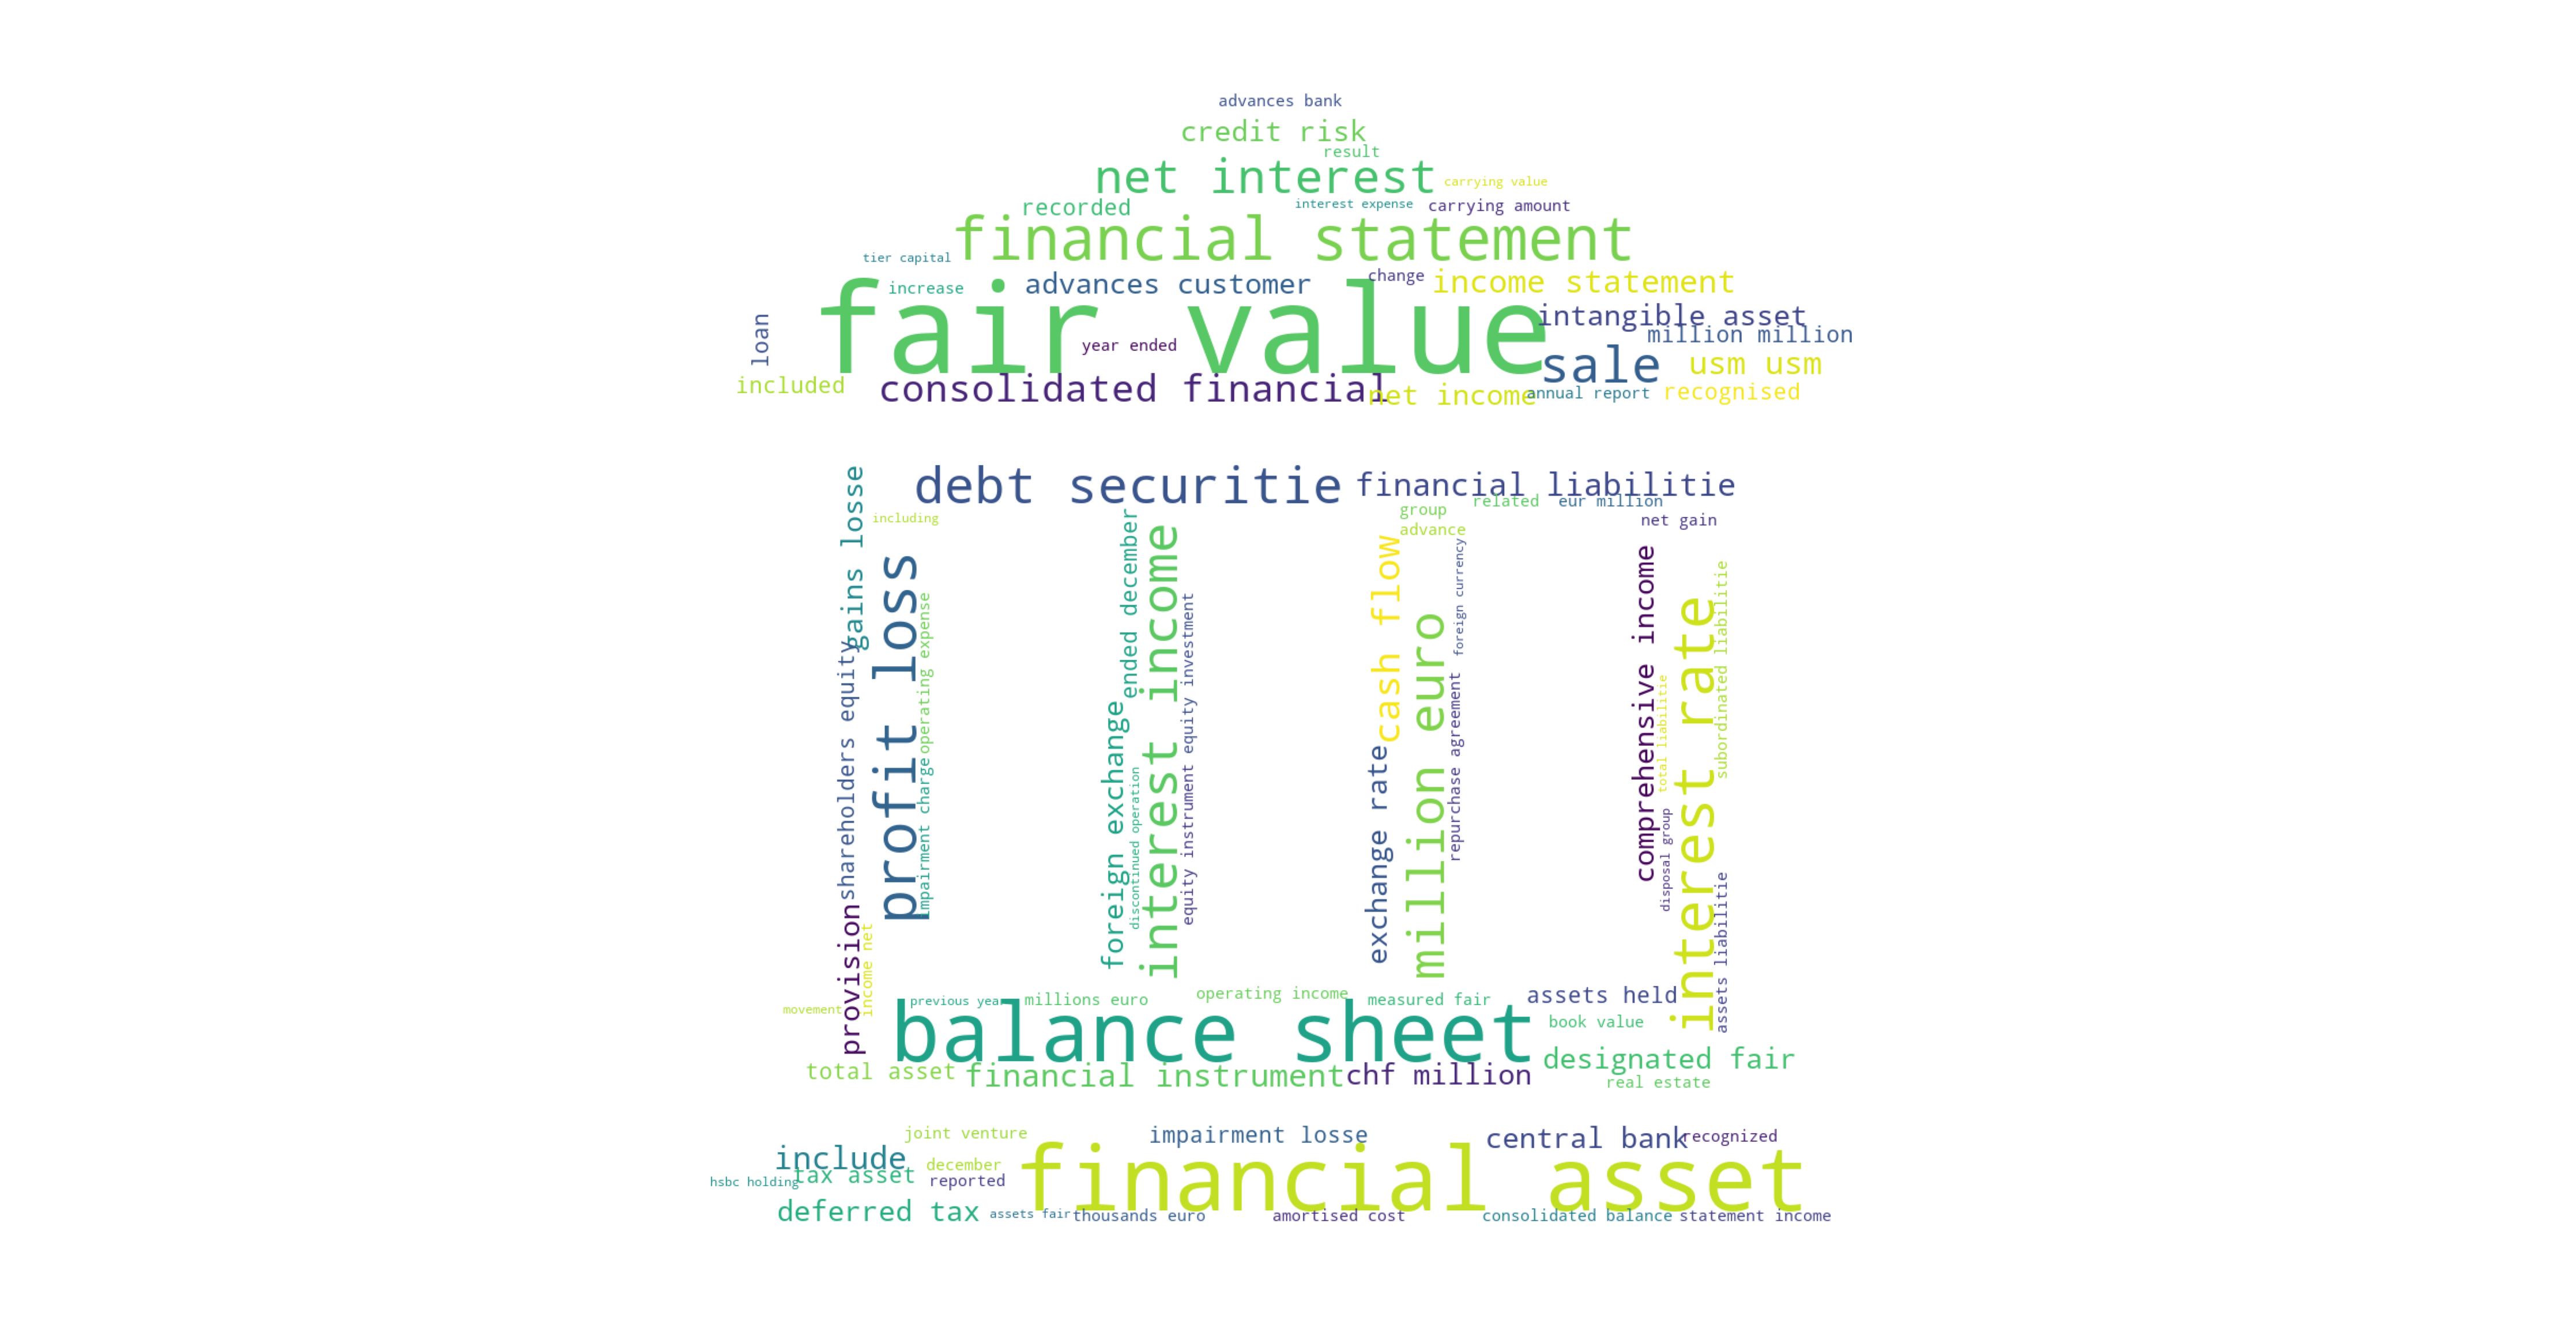

In [30]:
words_in_cluster = []

for frase in cluster_df[cluster_df.cluster == 1]['texto_vector'].to_numpy():
    words_in_cluster.extend(frase)
    
plotWordCloud(words_in_cluster, colormap='viridis')

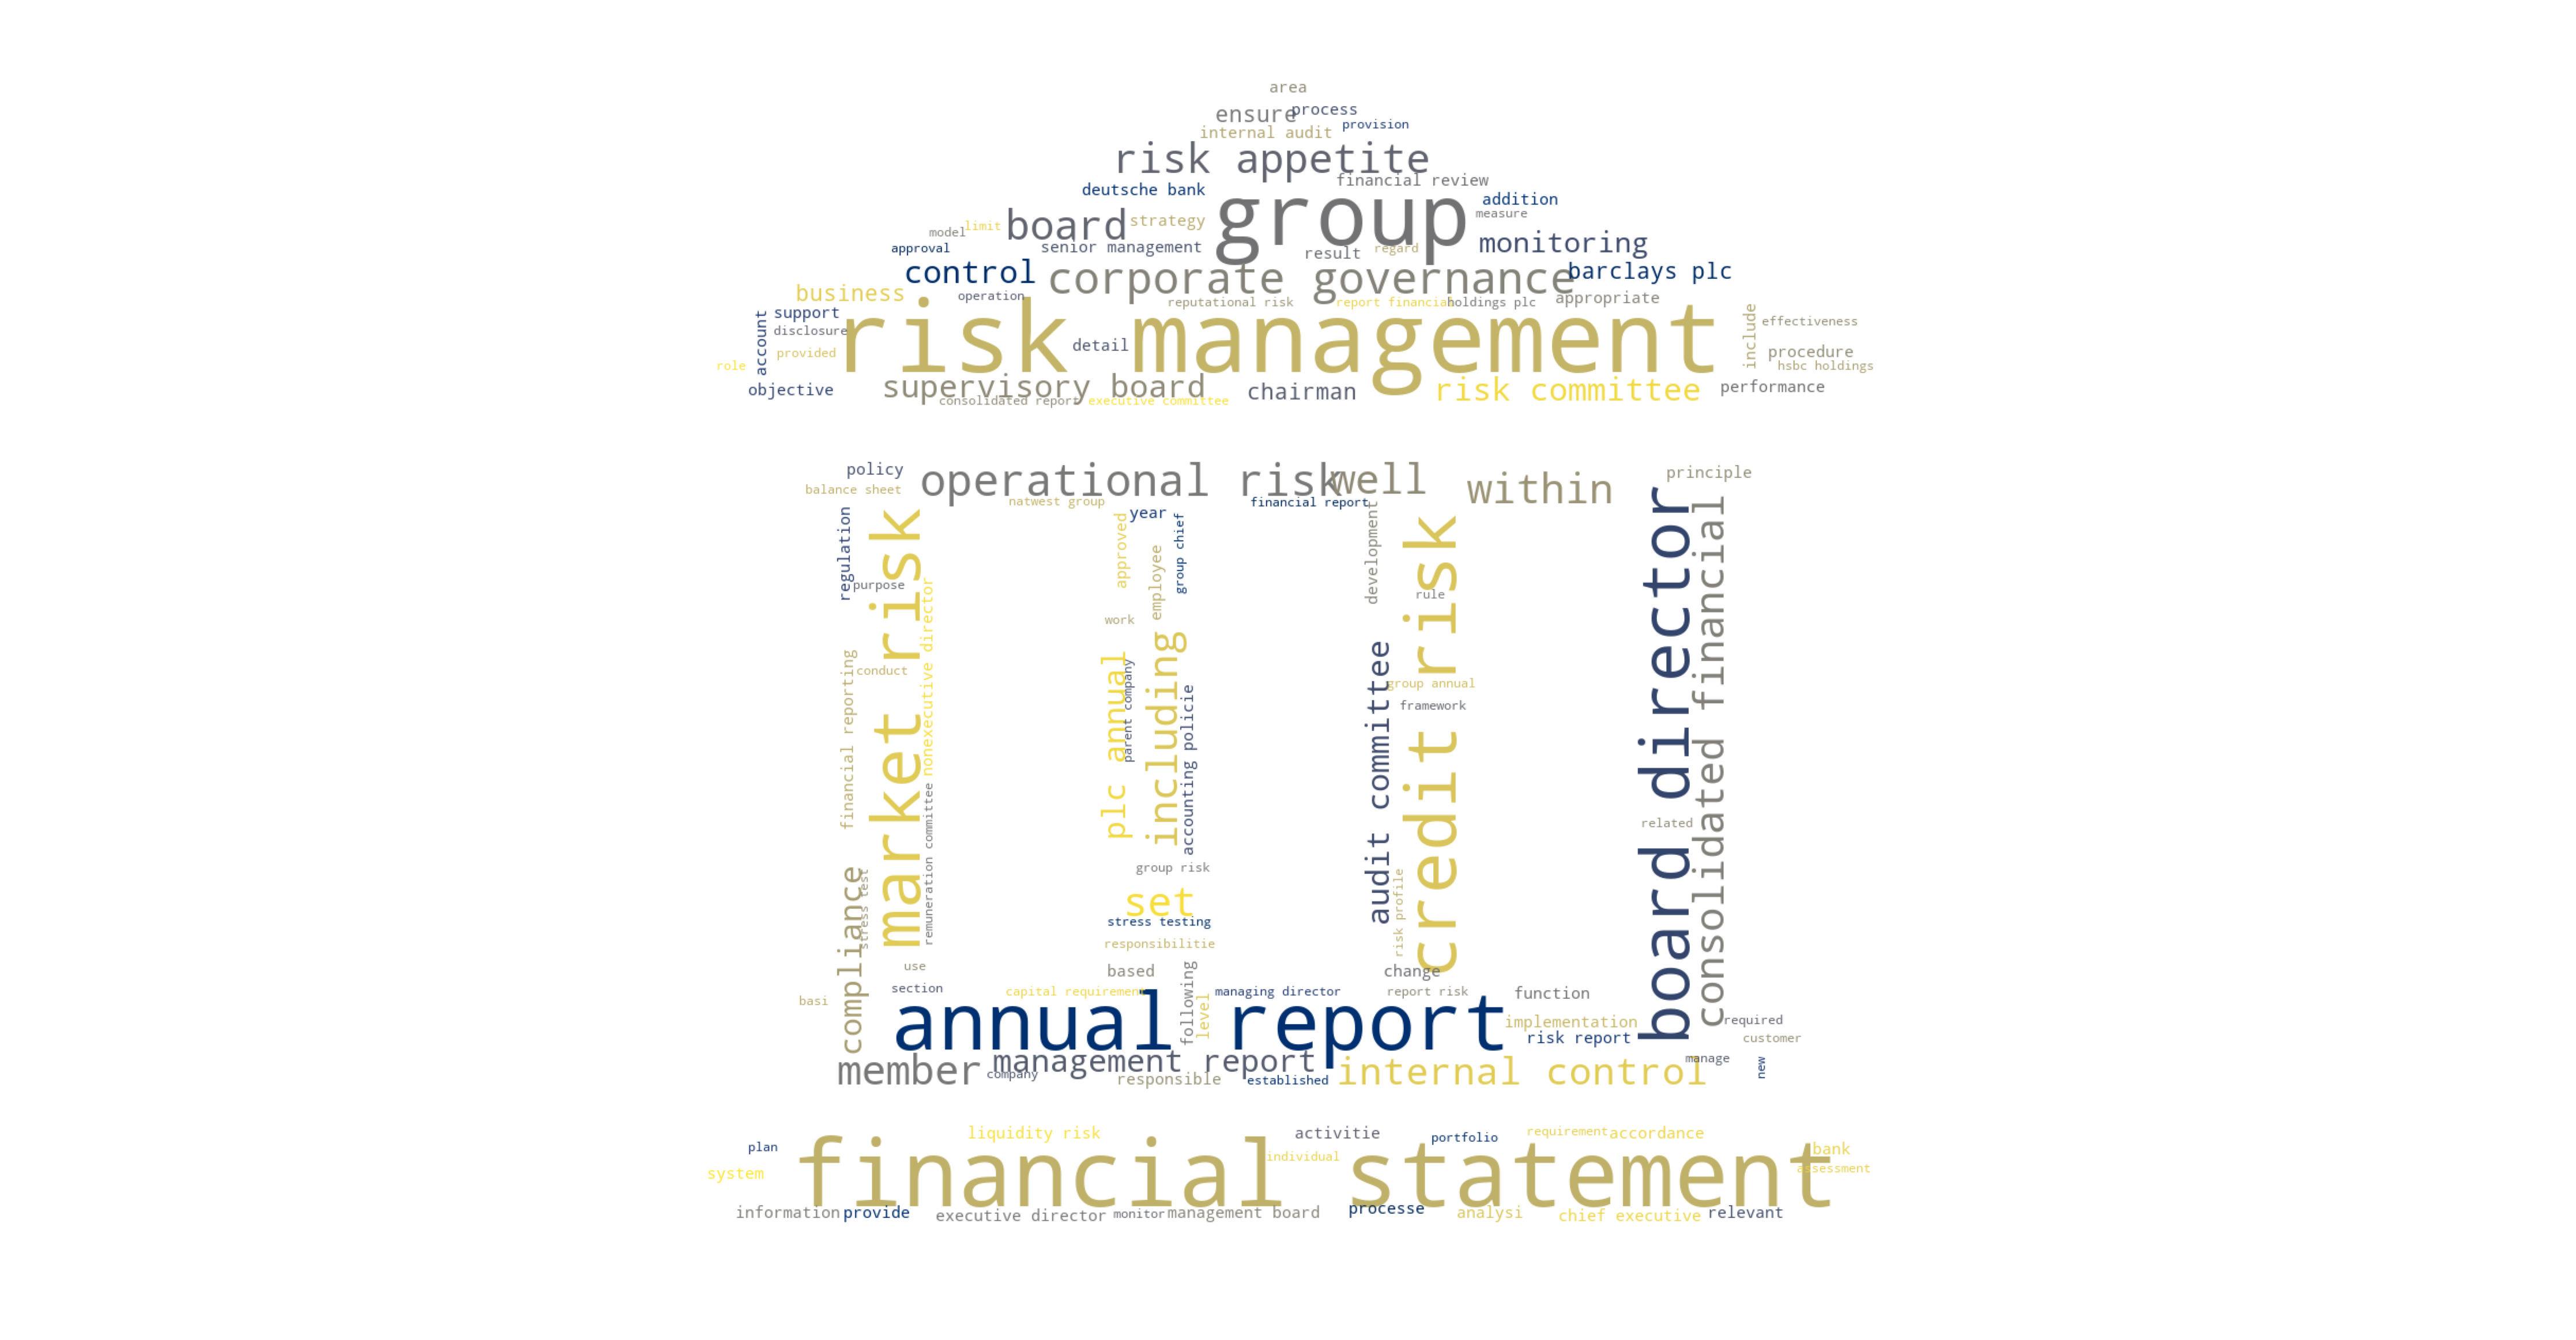

In [31]:
words_in_cluster = []

for frase in cluster_df[cluster_df.cluster == 2]['texto_vector'].to_numpy():
    words_in_cluster.extend(frase)
    
plotWordCloud(words_in_cluster, colormap='cividis')

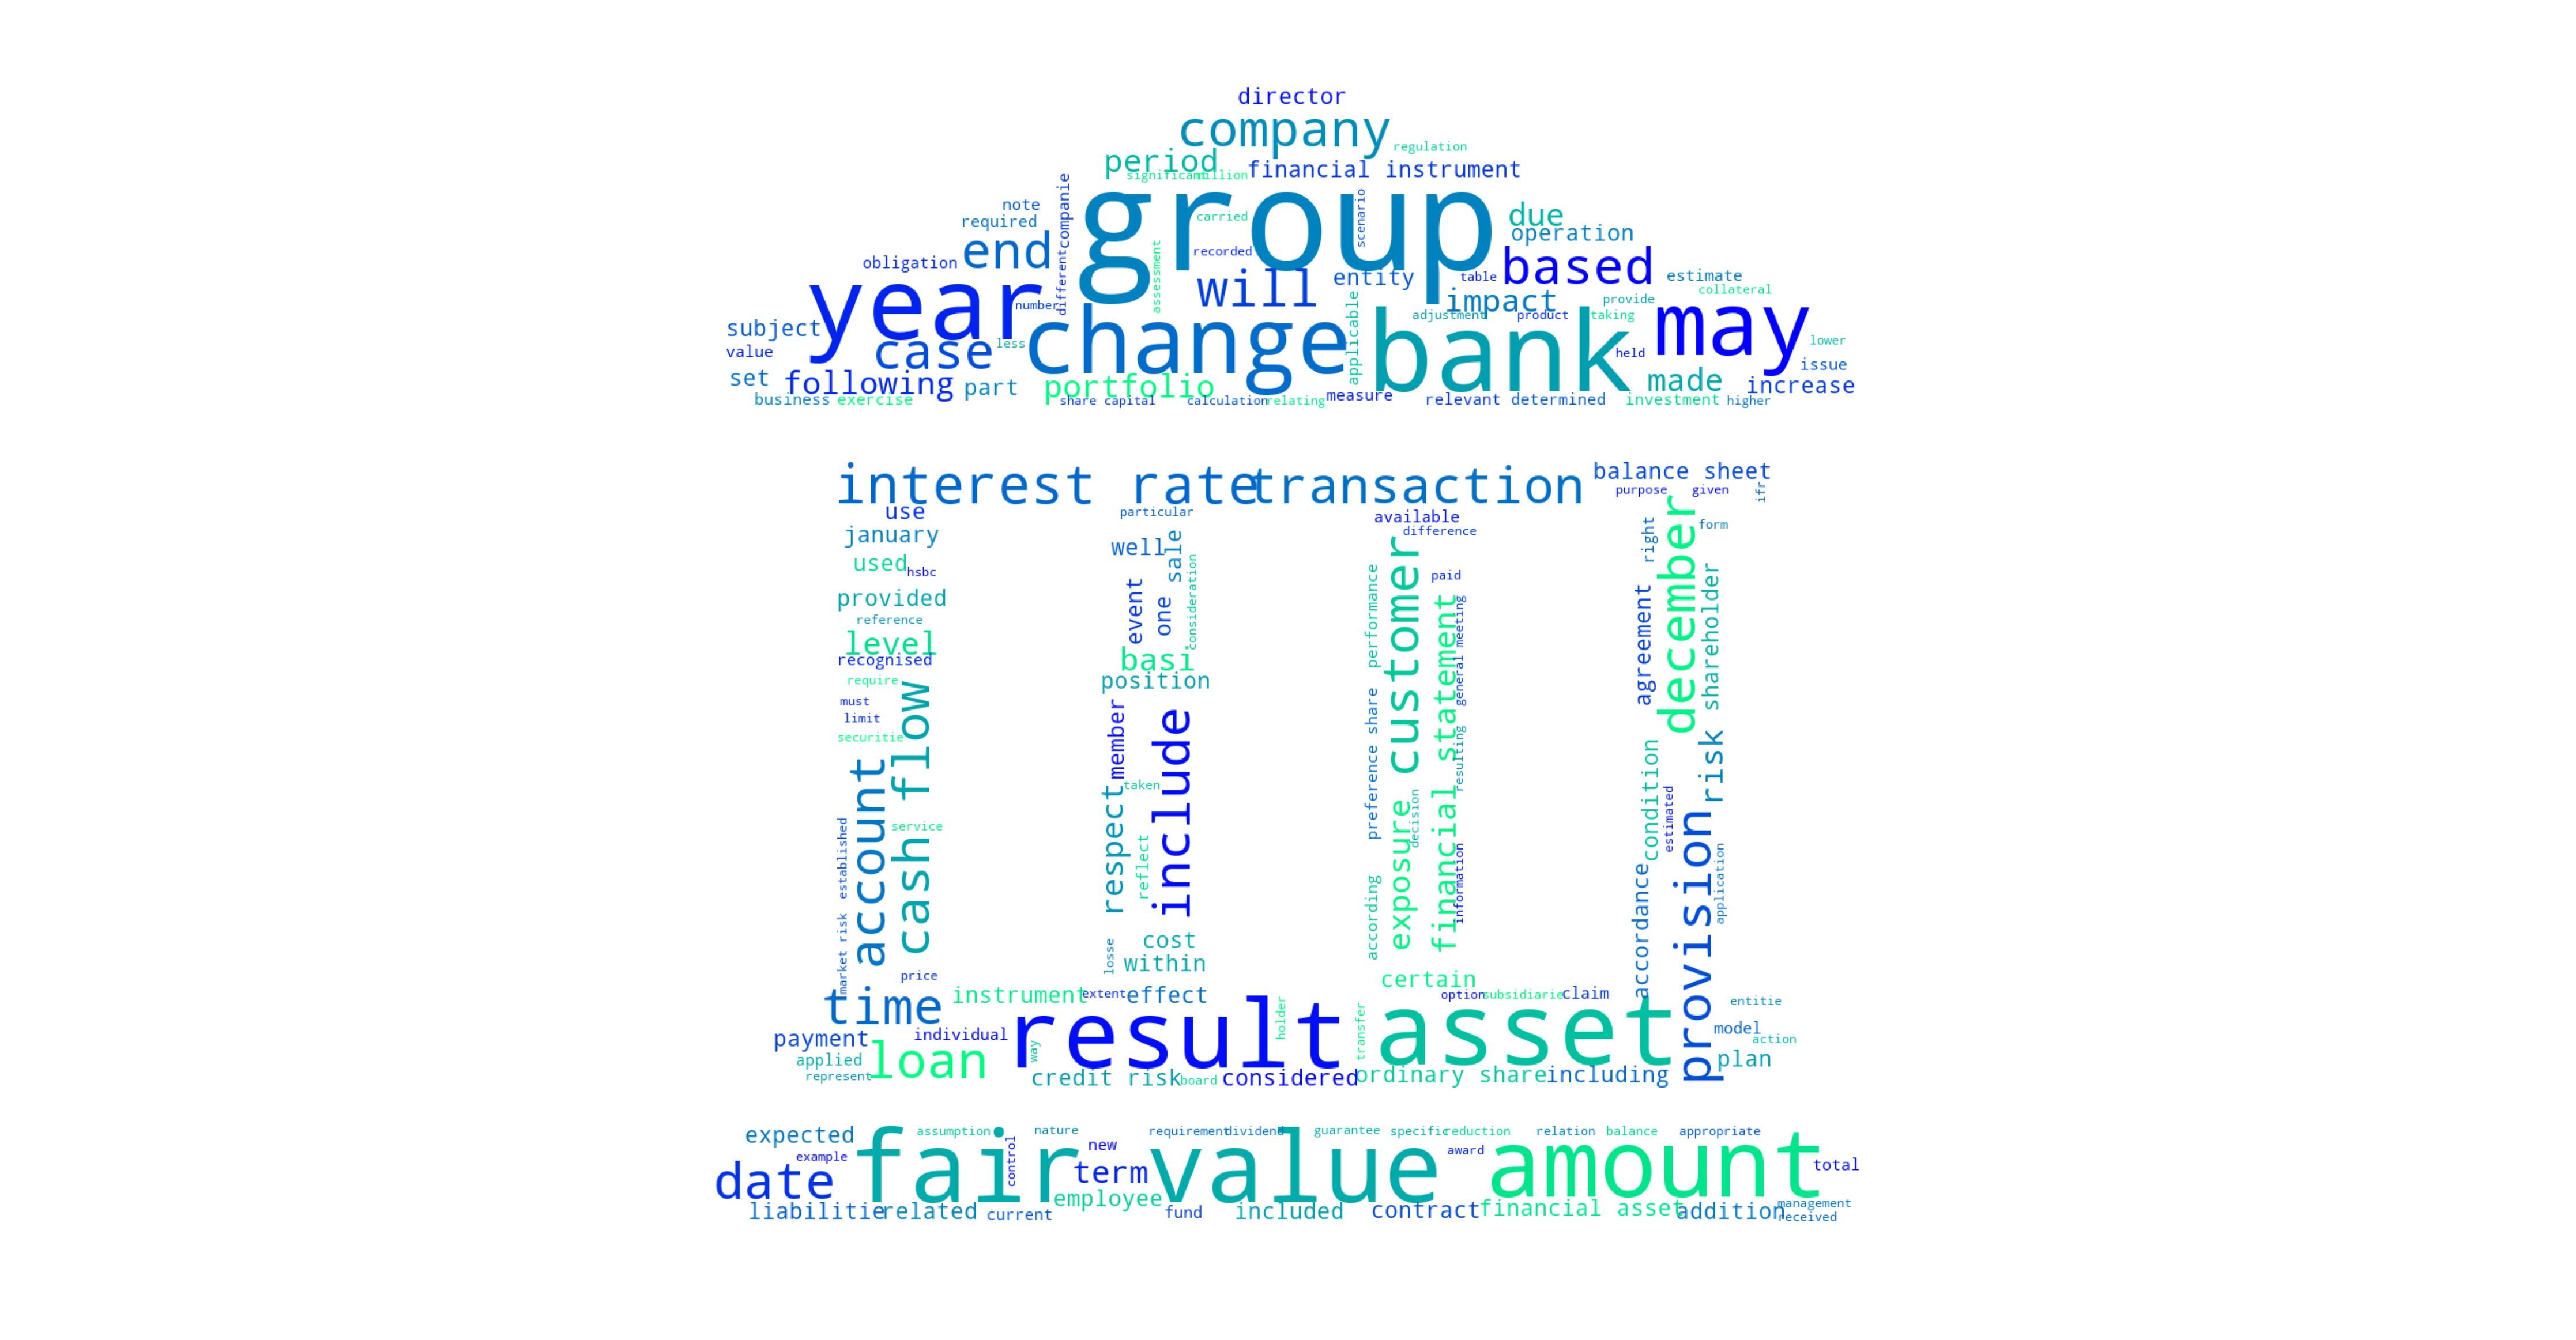

In [32]:
words_in_cluster = []

for frase in cluster_df[cluster_df.cluster == 3]['texto_vector'].to_numpy():
    words_in_cluster.extend(frase)
    
plotWordCloud(words_in_cluster, colormap='winter')

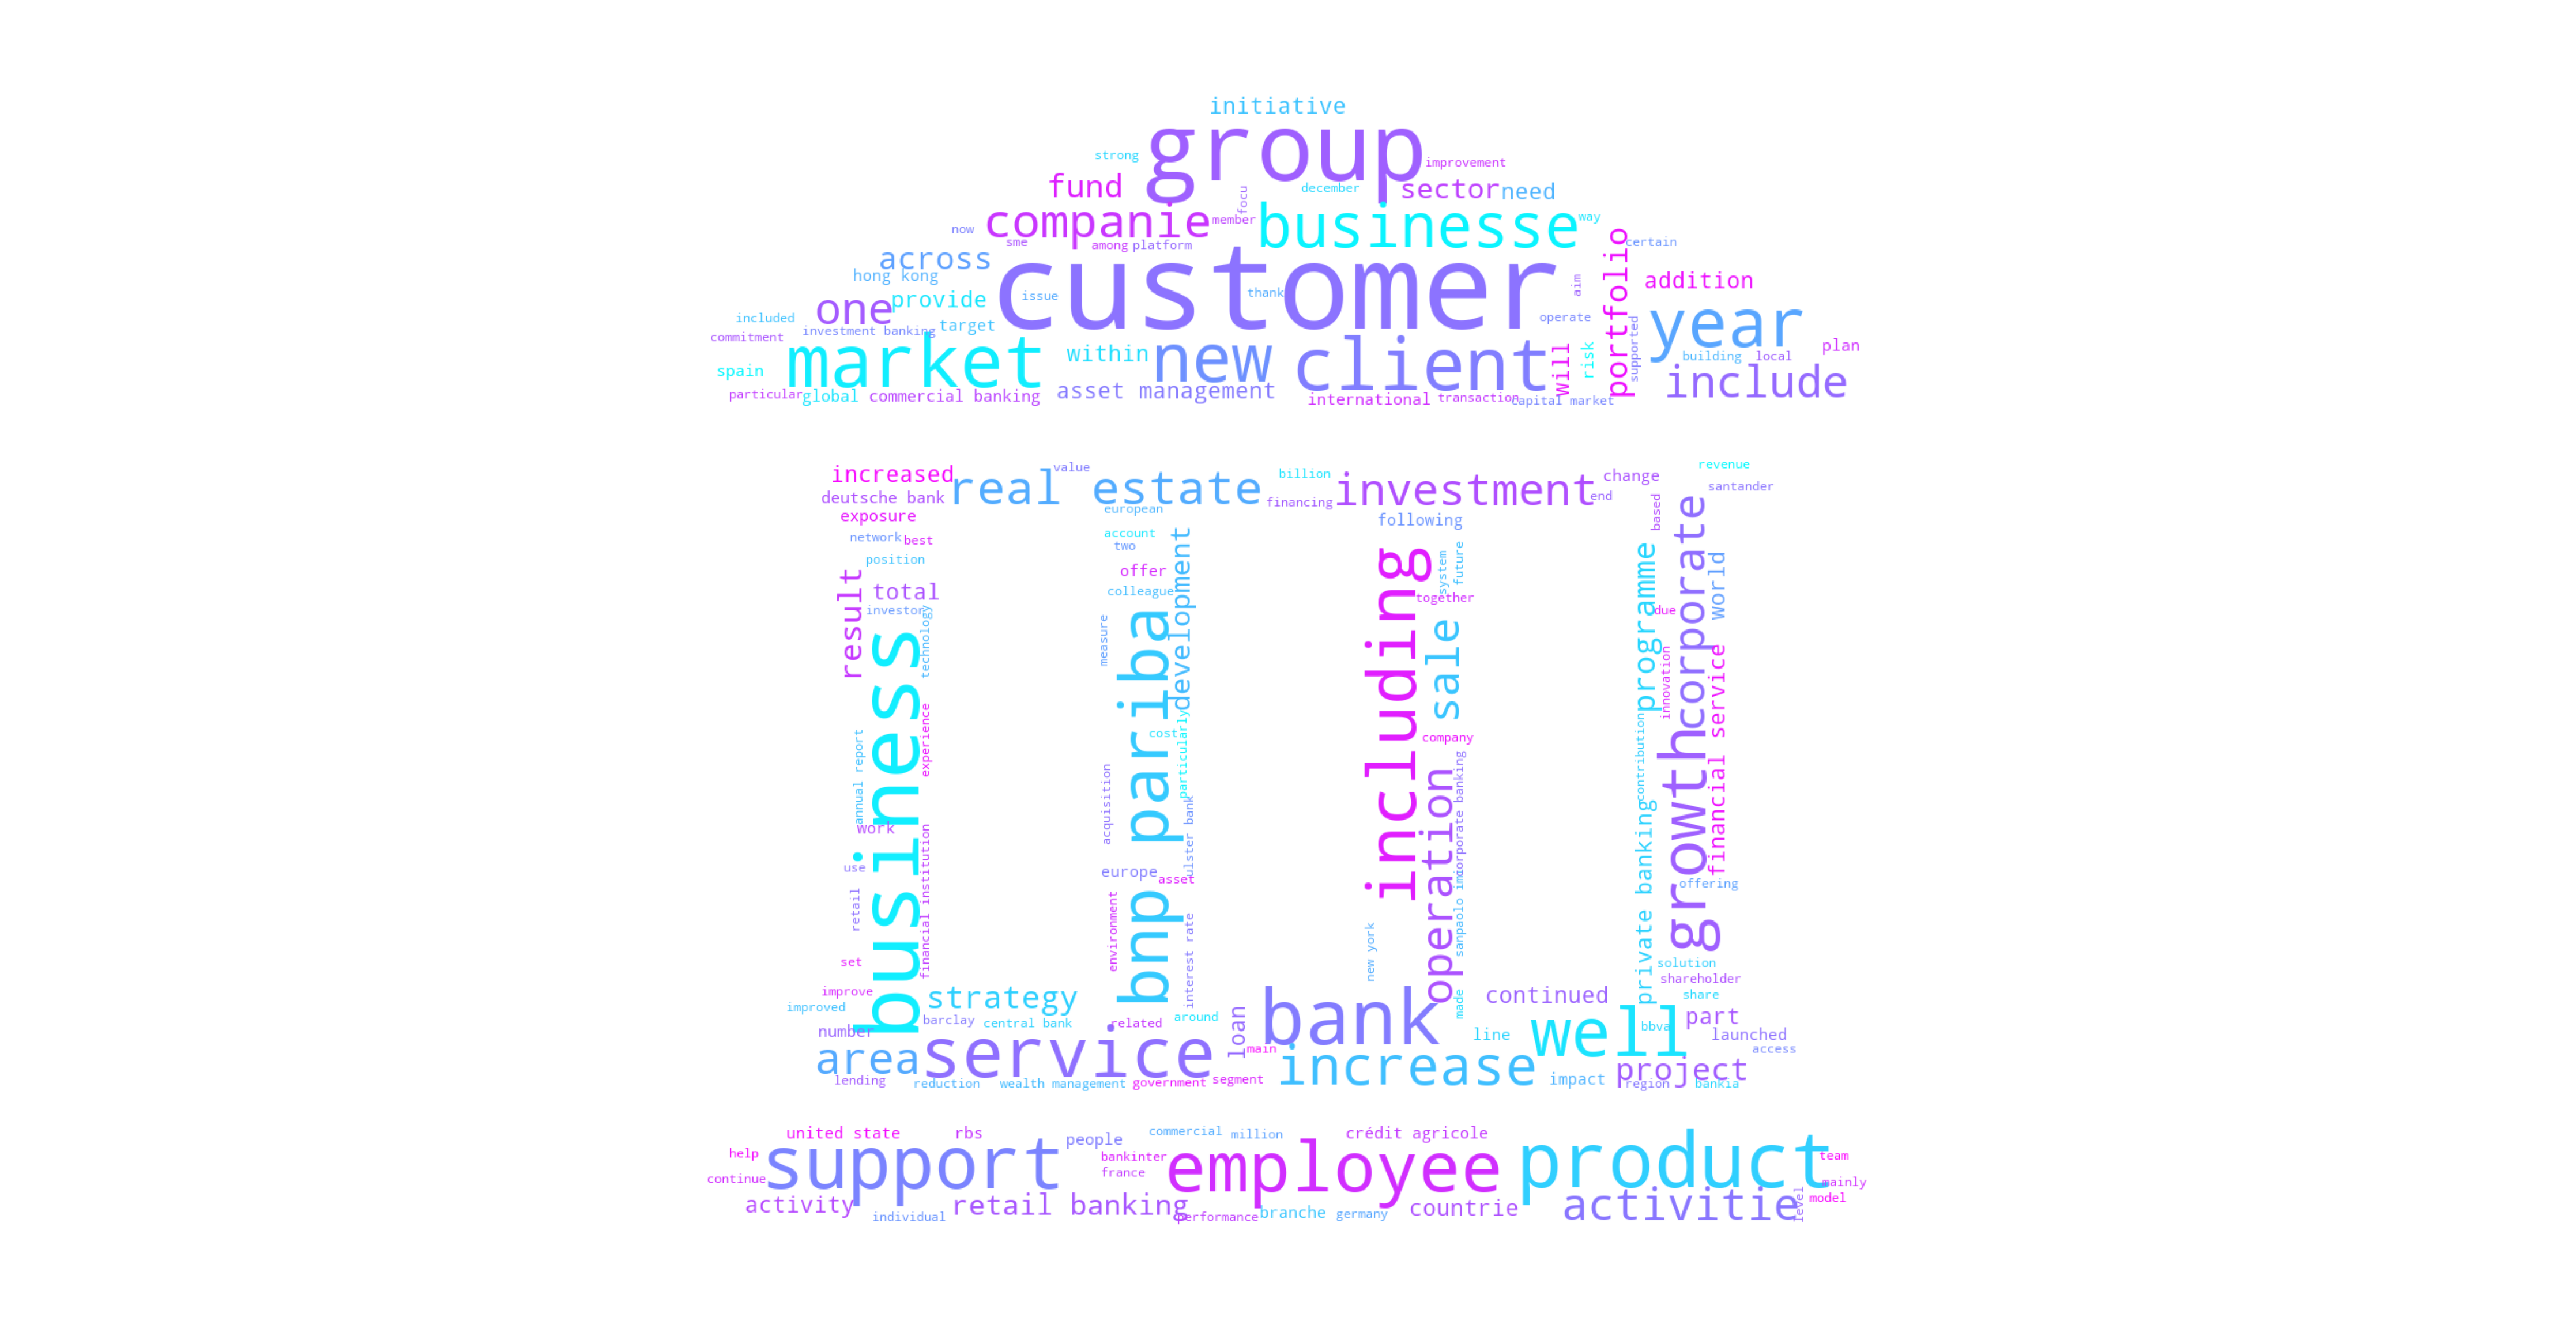

In [33]:
words_in_cluster = []

for frase in cluster_df[cluster_df.cluster == 4]['texto_vector'].to_numpy():
    words_in_cluster.extend(frase)
    
plotWordCloud(words_in_cluster, colormap='cool')